In [1]:
########################## 这个是最终的结果，之前的相关性写错了 ##############
#关于文档的一个数据分类
import pandas as pd
import seaborn as sns  #用于绘制热图的工具包
from scipy.cluster import hierarchy  #用于进行层次聚类，话层次聚类图的工具包
from scipy import cluster   
import matplotlib.pyplot as plt
from sklearn import decomposition as skldec #用于主成分分析降维的包
import numpy as np
#import csv
import math
from pandas import Series,DataFrame
from matplotlib.ticker import  MultipleLocator
import pylab as pl   #画图用
from sklearn import svm
from sklearn import linear_model

In [2]:
pop=['2000Pop','2001Pop','2002Pop','2003Pop','2004Pop','2005Pop','2006Pop','2007Pop','2008Pop','2009Pop',
     '2010Pop','2011Pop','2012Pop','2013Pop','2014Pop','2015Pop','2016Pop','2017Pop']
gdp=['2000GDP','2001GDP','2002GDP','2003GDP','2004GDP','2005GDP','2006GDP','2007GDP','2008GDP','2009GDP',
     '2010GDP','2011GDP','2012GDP','2013GDP','2014GDP','2015GDP','2016GDP','2017GDP']
area=['2000Area','2001Area','2002Area','2003Area','2004Area','2005Area','2006Area','2007Area','2008Area','2009Area',
     '2010Area','2011Area','2012Area','2013Area','2014Area','2015Area','2016Area','2017Area']
roadleng=['2000Roadleng','2001Roadleng','2002Roadleng','2003Roadleng','2004Roadleng','2005Roadleng','2006Roadleng','2007Roadleng','2008Roadleng','2009Roadleng',
     '2010Roadleng','2011Roadleng','2012Roadleng','2013Roadleng','2014Roadleng','2015Roadleng','2016Roadleng','2017Roadleng']
inv_times=['2000invtime','2001invtime','2002invtime','2003invtime','2004invtime','2005invtime','2006invtime','2007invtime','2008invtime','2009invtime',
     '2010invtime','2011invtime','2012invtime','2013invtime','2014invtime','2015invtime','2016invtime','2017invtime']
investment=['2000inv','2001inv','2002inv','2003inv','2004inv','2005inv','2006inv','2007inv','2008inv','2009inv',
     '2010inv','2011inv','2012inv','2013inv','2014inv','2015inv','2016inv','2017inv']

In [3]:
data =pd.read_excel('E:/文档系列/python 系列/TheData/0_theDATA_end(1991-2017pop&GDP&vc)/ALL_Intersection.xlsx')  # 读取训练数据
city=data['City'].drop_duplicates().values
City=data['city'].drop_duplicates().values

In [4]:
from scipy.optimize import leastsq  ##引入最小二乘法算法
#需要拟合的函数func :指定函数的形状
def func(p,x):
    k,b=p
    return k*x+b

##偏差函数：x,y都是列表:这里的x,y更上面的Xi,Yi中是一一对应的
def error(p,x,y):
    return func(p,x)-y

plt.rcParams['font.sans-serif']=['Simhei']     #解决中文显示问题，目前只知道黑体可行
plt.rcParams['axes.unicode_minus']=False       #解决负数坐标显示问题

In [5]:
##### 求残差 logy-log（kx+b）
def GuiJI(data,xl,yl,i,xname,yname):
    ###xl,yl：列名的list,xname,yname：列名,i:年份
    city=data['City'].drop_duplicates().values
    province=data['province'].values###得到省
    r=[]  ###标度率
    ###保存取完log后大于0的值
    p=[]
    g=[]
    ###取列值的log
    XI=data[xl[i]]
    YI=data[yl[i]]
    xi=np.log(XI)
    yi=np.log(YI)
    XII=xi.fillna(np.infty) ###将空值置为inf
    YII=yi.fillna(np.infty)
    ###判断是否大于0
    City=[]###保存log值大于0的城市名
    pro=[]###保存log值大于0的省名
    for mm in range(len(XII)):
        if XII[mm]==-float('Inf') or XII[mm]==float('Inf') or YII[mm]==-float('Inf') or YII[mm]==float('Inf'):
            continue
        else:
            p.append(XII[mm])
            g.append(YII[mm])
            City.append(city[mm])
            pro.append(province[mm])
                           
    #k,b的初始值，可以任意设定,经过几次试验，发现p0的值会影响cost的值：Para[1]
    p0=[1,10]
    Xi=np.array(p)
    Yi=np.array(g)
    #把error函数中除了p0以外的参数打包到args中(使用要求)
    Para=leastsq(error,p0,args=(Xi,Yi))## 三个参数：误差函数、函数参数列表、数据点
    #读取结果
    k,b=Para[0]
    ###将标度率写入r中
    r.append(k) 
    y = [k*x+b for x in p]
    ###得到残差
    sc=[g[v]-y[v] for v in range(len(g))]
    
    ###计算频率分布
    maxsc=max(sc)
    minsc=min(sc)
    Paragraph_len=(maxsc-minsc)/10
    fresc=[]###频率
    xvalue=[] ###坐标所在数段
    for i in range(10):
        num=0
        psc=minsc+Paragraph_len*i ###左坐标
        rpsc=psc+Paragraph_len    ###右坐标
        for scj in sc:
            if scj>=psc and scj<rpsc:
                num=num+1
        fresc.append(num/len(City))
        xvalue.append((psc+rpsc)/2)
        
    ###按照sc的值进行排序
    scdic = list(zip(sc,City))
    scSort = sorted( scdic)###残差城市排序
    prodic = list(zip(sc,pro))
    proSort = sorted( prodic)
    return(r,City,p,g,y,sc,fresc,xvalue,scSort,k,b,proSort)

In [7]:
def getCity(s):
    a=list(s.split('|'))
    return(a[0])
data['province']=data.city.map(getCity)
province=data['province'].drop_duplicates().values###得到省

In [8]:
###热图
###每一个城市的残差的均值
### 相关性应该是 平方和开方为分母，连×之和为分子
def get_cij(scall,cityname):
    dfscyear = pd.DataFrame(scall, columns=cityname)###将每一年的残差转化为dataframe city*year
    ###求Cij
    Cij=[]
    for i in range(len(cityname)):
        c1=dfscyear[cityname[i]].values###得到城市1的残差
        c1Sum = 0
        for ccc in range(18):
            c1Sum += c1[ccc]**2 ###城市17年间残差平方连加
        lenc1 = math.sqrt(c1Sum)###得到分母
        #absc1=cityAvg[i]
        cij=[]
        for j in range(len(cityname)):
            c2=dfscyear[cityname[j]].values###得到城市2的残差
            addc12=0
            c2Sum = 0
            for c in range(18):
                mul=c1[c]*c2[c]
                addc12=addc12+mul
                c2Sum += c2[c]**2 ###城市17年间残差平方连加
            lenc2 = math.sqrt(c2Sum)###得到分母
            c12=addc12/(lenc1*lenc2)
            cij.append(c12)###两个城市cij
        Cij.append(cij)
    dfCij= pd.DataFrame(Cij)  
    return(dfCij)

In [6]:
#################  1. GMP ##########

In [9]:
########## 
cityM = GuiJI(data,pop,investment,15,'pop','amount')[1]###按照2015年含有投资金额的城市来删选2000-2016年间关于GDP\amount\times的数据
####查看一些城市2000-2016年的残差分布图
scall=[]###保存所有城市2000-2016年的残差
scallM=[]
scallT=[]
for i in range(18):    
    ### GDP残差
    sami=GuiJI(data,pop,gdp,i,'pop','GDP')
    sc=sami[5]###获取某一年的残差值
    cityname=sami[1]###城市名

    ###amount
    samiM=GuiJI(data,pop,investment,i,'pop','amount')
    scM=samiM[5]###获取某一年的残差值
    citynameM=samiM[1]###城市名

    ###times
    samiT=GuiJI(data,pop,inv_times,i,'pop','times')
    scT=samiT[5]###获取某一年的残差值
    citynameT=samiT[1]###城市名
 
    ### 删选出来含有投资的城市的GDP\TIMES
    sc_GDP0=[] ###保存含有投资的城市的GDP
    sc_amount0 = [] ###投资金额
    sc_times0=[] ###保存旱藕投资的城市的投资次数
    
    ### 1 得到GDP的数据
    for c1 in cityM:
        have = 0 ###标志该城市是否存在,0表示不存在
        for c2 in range(len(cityname)):
            if cityname[c2] == c1:
                sc_GDP0.append(sc[c2])
                have = 1
        if have == 0:
            sc_GDP0.append(0)
    ### 2 得到投资金额的数据
    for c1 in cityM:
        have1 = 0 ###标值该城市是否存在,0表示不存在
        for c2 in range(len(citynameM)):
            if citynameM[c2] == c1:
                sc_amount0.append(scM[c2])
                have1 = 1
        if have1 == 0:
            sc_amount0.append(0)
    ### 3 得到投资次数的残差数据
    for c1 in cityM:
        have2 = 0
        for c2 in range(len(citynameT)):
            if citynameT[c2] == c1:
                sc_times0.append(scT[c2])
                have2 = 1
        if have2 == 0:
            sc_times0.append(0)
            
    scallM.append(sc_amount0)###得到删选后的残差,城市和投资金额城市保持一致
    scallT.append(sc_times0)
    scall.append(sc_GDP0)

D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


In [10]:
################ 得到相关性矩阵
dfAmount = get_cij(scallM,cityM)
dfTimes = get_cij(scallT,cityM)
dfGDP = get_cij(scall,cityM)

In [11]:
### 按照相关性对其进行聚类 ###
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline
from scipy.cluster.hierarchy import fcluster
### 1. amount聚类结果
ptdM=(1-dfAmount)/2
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
Z11M3 = linkage(ptdM, 'ward')
clusters_M3 = fcluster(Z11M3,3, criterion='maxclust')

###times 聚为三类
ptdT=(1-dfTimes)/2
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
Z11T3 = linkage(ptdT, 'ward')
clusters_T3 = fcluster(Z11T3,3, criterion='maxclust')

###GDP
ptdG=(1-dfGDP)/2
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
Z11G3 = linkage(ptdG, 'ward')
clusters_G3 = fcluster(Z11G3,3, criterion='maxclust')

In [19]:
cludf3=pd.DataFrame()###保存城市和分类在dataframe,并将每一类分类对应不同颜色
cludf3['city']=cityM
cludf3['clusterM3']=clusters_M3
cludf3['clusterT3']=clusters_T3
cludf3['clusterG3']=clusters_G3
yj_color = {1:(0.7247999999999999, 0.86, 0.33999999999999997),2:(0.86, 0.3712, 0.33999999999999997),3:'#FF9933',4:(0.33999999999999997, 0.5167999999999995, 0.86)}
a=list(sns.color_palette("hls", 26))
yj_color2={1:(0.86, 0.3712, 0.33999999999999997),2:'#FF9933',3:a[15]}###让times显示不同的颜色

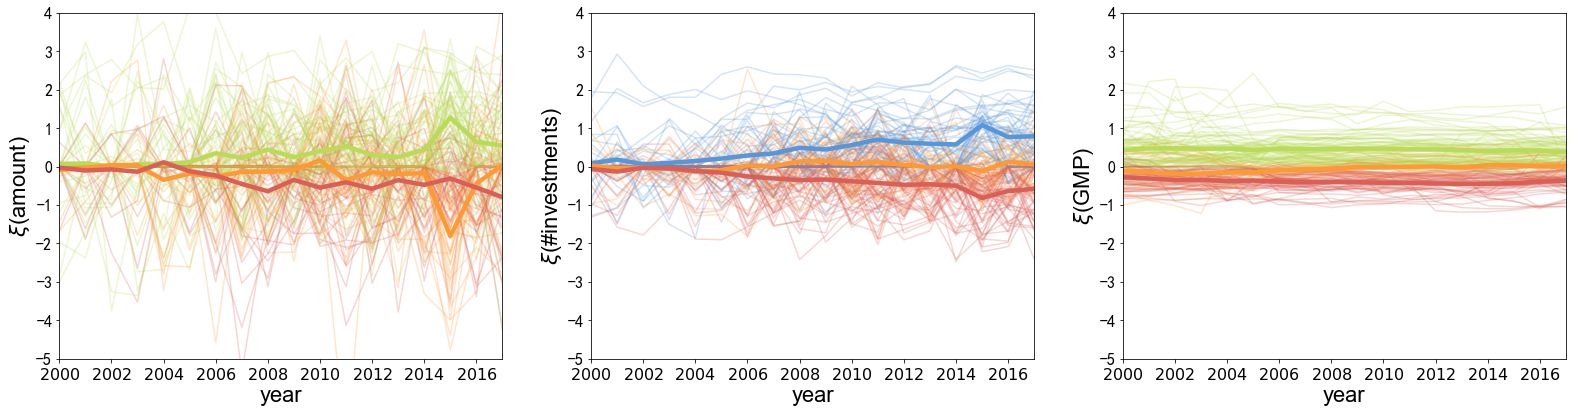

In [20]:
########### 保存到文件里面  ##########################
##### 1. amount分类情况
from matplotlib.ticker import FuncFormatter   ### 今天的主角
fig=plt.figure(figsize=(27,14))
yearsL = list(map(int,list(range(2000,2018,1))))
xmajorLocator = MultipleLocator(2)
xminorLocator = MultipleLocator(1)###设置刻度
x_major_locator=MultipleLocator(2)
ax1=fig.add_subplot(231)
def formatnum2(x, pos):
    return '$%.0f$' % x
def formatnum(x, pos):
    return '$%.2f$' % x
formatter2 = FuncFormatter(formatnum2)
ax1.xaxis.set_major_formatter(formatter2)
dfscyearM = pd.DataFrame(scallM, columns=cityM)###将每一年的残差转化为dataframe city*year
ss2M=pd.DataFrame(scallM)
ssM3=ss2M.T
ssM3['class']=clusters_M3###将聚类结果作为新列写进去
clsM3=ssM3['class'].drop_duplicates().values###得到的分类数作为新列写进去
DATAM3=[]###按照城市对数据进行分组
avg_csM3=[]###每一组里面的每一列的均值
for liM in clsM3:
    datM3=ssM3[ssM3['class'].isin([liM])]
#     DATAG.append(dat)
    sssM3=pd.DataFrame(datM3).iloc[:,0:18]
    avg_csM3.append(sssM3.mean(axis=0))

font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 22,
    }###设置横纵坐标的字体格式
plt.ylim(-5,4)
plt.xlabel('year',font2)
plt.ylabel(r'$\xi$'+'(amount)',font2)#Residual_Amount
plt.tick_params(labelsize=16) #刻度字体大小13
acity=[]
for c in range(len(cityM)):
    citySC2=dfscyearM[cityM[c]]
    acity.append(citySC2.values)
    x=np.arange(2000,2018)
    plt.xlim(2000,2017)
    plt.plot(x,citySC2, alpha=0.25,color=yj_color[clusters_M3[c]])#marker='o',

for pp in range(len(avg_csM3)):
    plt.plot(x,avg_csM3[pp],color=yj_color[clsM3[pp]],linewidth=4.5)
    
    
############ 2 times ################
ax2=fig.add_subplot(232)
ax2.xaxis.set_major_formatter(formatter2)
dfscyearT = pd.DataFrame(scallT, columns=cityM)###将每一年的残差转化为dataframe city*year
ss2T=pd.DataFrame(scallT)
ssT3=ss2T.T
ssT3['class']=clusters_T3###将聚类结果作为新列写进去
clsT3=ssT3['class'].drop_duplicates().values###得到的分类数作为新列写进去
DATAT3=[]###按照城市对数据进行分组
avg_csT3=[]###每一组里面的每一列的均值
for liT in clsT3:
    datT3=ssT3[ssT3['class'].isin([liT])]
#     DATAG.append(dat)
    sssT3=pd.DataFrame(datT3).iloc[:,0:18]
    avg_csT3.append(sssT3.mean(axis=0))

plt.tick_params(labelsize=16) #刻度字体大小13
plt.xlabel('year',font2)
plt.ylabel(r'$\xi$'+'(#investments)',font2)
plt.ylim(-5,4)
for c in range(len(cityM)):
    citySC3=dfscyearT[cityM[c]]
    x=np.arange(2000,2018)
    plt.xlim(2000,2017)
    plt.plot(x,citySC3,alpha=0.25,color=yj_color2[clusters_T3[c]])
for pp in range(len(avg_csT3)):
    plt.plot(x,avg_csT3[pp],color=yj_color2[clsT3[pp]],linewidth=4.5)
    
    
############ 3 GDP################
ax3=fig.add_subplot(233)
ax3.xaxis.set_major_formatter(formatter2)
dfscyearG = pd.DataFrame(scall, columns=cityM)###将每一年的残差转化为dataframe city*year
ss2G=pd.DataFrame(scall)
ssG3=ss2G.T
ssG3['class']=clusters_G3###将聚类结果作为新列写进去
clsG3=ssG3['class'].drop_duplicates().values###得到的分类数作为新列写进去
DATAG3=[]###按照城市对数据进行分组
avg_csG3=[]###每一组里面的每一列的均值
for liT in clsG3:
    datG3=ssG3[ssG3['class'].isin([liT])]
#     DATAG.append(dat)
    sssG3=pd.DataFrame(datG3).iloc[:,0:18]
    avg_csG3.append(sssG3.mean(axis=0))

plt.tick_params(labelsize=16) #刻度字体大小13
plt.xlabel('year',font2)
plt.ylabel(r'$\xi$'+'(GMP)',font2)
plt.ylim(-5,4)
for c in range(len(cityM)):
    citySC3=dfscyearG[cityM[c]]
    x=np.arange(2000,2018)
    plt.xlim(2000,2017)
    plt.plot(x,citySC3,alpha=0.25,color=yj_color[clusters_G3[c]])
for pp in range(len(avg_csG3)):
    plt.plot(x,avg_csG3[pp],color=yj_color[clsG3[pp]],linewidth=4.5)
plt.savefig('E:/文档系列/python 系列/picScalling/20201025NEW/map/Fig3_abc3.pdf', bbox_inches='tight')